WORLD BANK DEVELOPMENT INDICATORS

This package helps in exploring the different world bank indicators for different countries.
Some useful functions for exploring this data include;
1. get_indicators()
2. get_series()
3. get_sources()
4. search_sources()


In [38]:
import warnings
warnings.simplefilter("ignore")
from pandas_datareader.wb import WorldBankReader, get_indicators
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
indicators = get_indicators()
indicators_df = pd.DataFrame(indicators)
indicators_df.head()

,id,name,unit,source,sourceNote,sourceOrganization,topics
0,1.0.HCount.1.90usd,Poverty Headcount ($1.90 a day),,LAC Equity Lab,The poverty headcount index measures the propo...,b'LAC Equity Lab tabulations of SEDLAC (CEDLAS...,Poverty
1,1.0.HCount.2.5usd,Poverty Headcount ($2.50 a day),,LAC Equity Lab,The poverty headcount index measures the propo...,b'LAC Equity Lab tabulations of SEDLAC (CEDLAS...,Poverty
2,1.0.HCount.Mid10to50,Middle Class ($10-50 a day) Headcount,,LAC Equity Lab,The poverty headcount index measures the propo...,b'LAC Equity Lab tabulations of SEDLAC (CEDLAS...,Poverty
3,1.0.HCount.Ofcl,Official Moderate Poverty Rate-National,,LAC Equity Lab,The poverty headcount index measures the propo...,b'LAC Equity Lab tabulations of data from Nati...,Poverty
4,1.0.HCount.Poor4uds,Poverty Headcount ($4 a day),,LAC Equity Lab,The poverty headcount index measures the propo...,b'LAC Equity Lab tabulations of SEDLAC (CEDLAS...,Poverty


In [7]:
topic = indicators_df['topics'].unique()
print(topic)

['Poverty ' '' 'Education ' 'Social Protection & Labor' 'Economy & Growth'
 'Agriculture & Rural Development  '
 'Agriculture & Rural Development   ; Climate Change'
 'Agriculture & Rural Development   ; Climate Change ; Environment '
 'Climate Change ; Urban Development  ; Environment '
 'Climate Change ; Environment '
 'Agriculture & Rural Development   ; Environment '
 'Urban Development  ; Environment '
 'Economy & Growth ; Private Sector ; Trade' 'Economy & Growth ; Trade'
 'Economy & Growth ; Science & Technology '
 'Economy & Growth ; External Debt ; Trade'
 'Economy & Growth ; Financial Sector ' 'Economy & Growth ; External Debt'
 'External Debt' 'Economy & Growth ; External Debt ; Aid Effectiveness '
 'Economy & Growth ; Infrastructure  ; Trade'
 'Economy & Growth ; Financial Sector  ; External Debt'
 'Economy & Growth ; Financial Sector  ; Climate Change' 'Public Sector '
 'Financial Sector ' 'Aid Effectiveness ' 'Millenium development goals'
 'Aid Effectiveness  ; External D

In [8]:

gdp = WorldBankReader(symbols='NY.GDP.MKTP.CN', countries= 'KE', start=2009, end=2020).read()


In [11]:
# kenya's GDP for the last 20 years
gdp.head()

NY.GDP.MKTP.CN
country year                
Kenya   2020  10715070000000
        2019  10237727000000
        2018   9340307000000
        2017   8483396000000
        2016   7594064000000

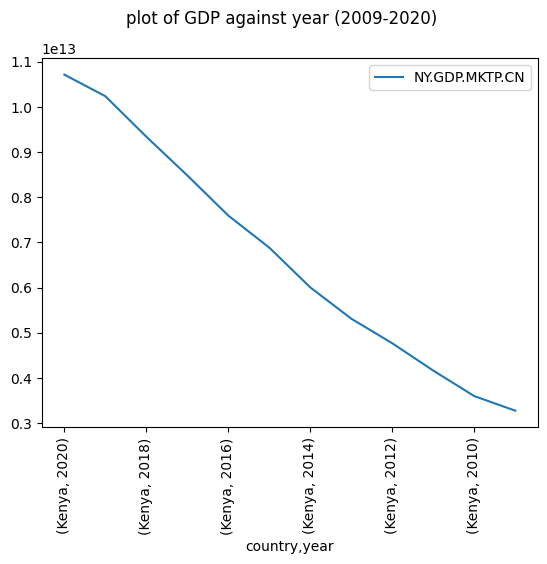

In [14]:
fig, ax = plt.subplots()
plt.suptitle('plot of GDP against year (2009-2020)')
gdp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [15]:
# The gdp series is clearly not stationary. we can also do the dicky fuller test for stationarity.
# null hypothesis is that the time series is not stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(gdp)

# Print the test statistic and the p-value. p-value is less than 0.05 we accept the null that series isn't stationary
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -17.628603119669265
p-value: 3.8080184171156934e-30


In [16]:
# compute the first difference to make the series stationary.but there's still some stationarity therefore take second diff
gdp_diff = gdp.diff().diff().dropna()


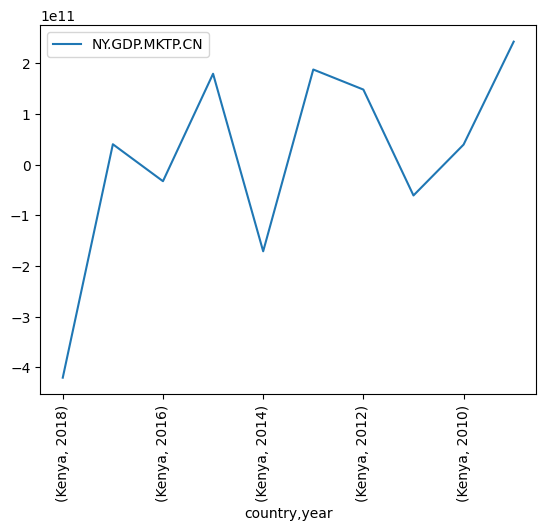

In [36]:
fig, ax = plt.subplots()
gdp_diff.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [37]:
# Let's try the log transformation
gdp_log = np.log(gdp/gdp.shift(1)).dropna()

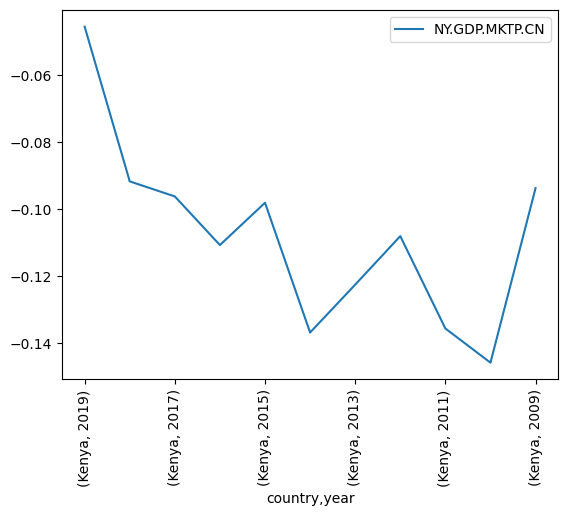

In [34]:
fig, ax = plt.subplots()
gdp_log.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [30]:
result1 = adfuller(gdp_diff)
result2 = adfuller(gdp_log)


In [39]:
""" when we compare the p-values of both transformations, the logarithm is greater than 0.05( Reject the null-- not stationary) meaning it is a better transformation 
in making our series stationary. that is what we shall use to fit the ARMA model.
"""

print(f"AdfullerStatistic: diff= {result1[0]} : log= {result2[0]}")
print(f"Pvalue:diff= {result1[1]}: log= {result2[1]}")

AdfullerStatistic: diff= -3.688943636245092 : log= 9.736600634868015
Pvalue:diff= 0.004271387073436407: log= 1.0


Fitting the ARMA model

In [40]:
gdp_log.head()

NY.GDP.MKTP.CN
country year                
Kenya   2019       -0.045572
        2018       -0.091741
        2017       -0.096228
        2016       -0.110744
        2015       -0.098121

In [41]:
# preapre the gdp_log df for modelling

# Drop country name from index
gdp_log= gdp_log.droplevel(level=0, axis=0)

In [42]:
gdp_log.head()

,NY.GDP.MKTP.CN
year,
2019,-0.045572
2018,-0.091741
2017,-0.096228
2016,-0.110744
2015,-0.098121


In [43]:
# Sort data in choronological order and set data point at year-end
gdp_log = gdp_log.set_index(pd.to_datetime(gdp_log.index))
gdp_log = gdp_log.sort_index().resample("y").last()

In [44]:

# instantiate a model object

model = ARIMA(endog=gdp_log , order = (1,2,1))

# fit model
results = model.fit()

In [45]:
# Forecast, and calculate the relative error
forecast = results.forecast(steps=4)
#df = pd.DataFrame({"Actual":gdp, "Forecast":forecast}).dropna()

In [46]:
print(forecast)

2020-12-31   -0.042652
2021-12-31   -0.025144
2022-12-31   -0.012557
2023-12-31    0.001690
Freq: A-DEC, Name: predicted_mean, dtype: float64


In [47]:
# kenya's GDP forecast for 2020
forecast_20  = 10 ** forecast[0]
print(forecast_20)

0.9064594247186053
